In [1]:
import sys
sys.path.append('../')
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
import ipywidgets as widgets
import bqplot

from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu,\
    NewRewardUtils as nr \

from reward import AWSReward, RewardFactory
import reward.awsreward as rewards
from utils.loader import load_logs, load_sample_complete_laps
from utils.transformer import df_to_params, calculate_iteration, new_names_df

tu = TrackIO(base_path='../tracks')
track = tu.load_track("reinvent_base")
fname = '../logs/training-simulation-logs-z6.log'

full_df = load_logs(fname)
calculate_iteration(full_df)

full_df['duration'] = full_df[['episode','numeric_timestamp']].groupby('episode').transform(lambda x: x - x.min())
df = full_df

from shapely.geometry import Point
is_in_track = lambda df: track.road_poly.contains( Point(df['x'],df['y']))


import warnings
warnings.filterwarnings('ignore')

Loaded 71 waypoints


In [2]:
df['in_track'] = df.apply(is_in_track,axis=1)

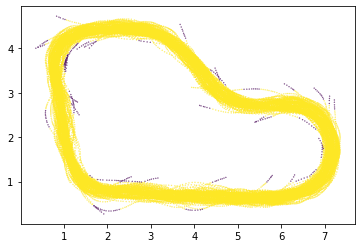

In [3]:
x,y,step,in_track = df['x,y,step,in_track'.split(',')].values.T
plt.scatter(x,y,c=in_track,s=0.1)

In [4]:
xmax, ymax = df[['x','y']].max().values
xx,yy = numpy.meshgrid(numpy.linspace(0,xmax*1.1,100),numpy.linspace(0,ymax*1.1,100))

x,y = xx.reshape(-1), yy.reshape(-1)
z = numpy.zeros_like(x)

def f(x,y):
    return track.road_poly.contains(Point(x,y))*1.0

fv = numpy.vectorize(f)

z = fv(x,y) * numpy.exp((-(x-numpy.mean(x))**2-(y-numpy.mean(y))**2)/5)

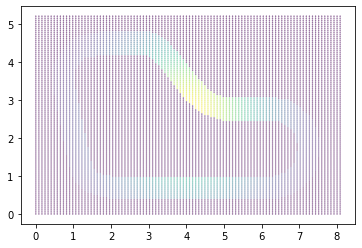

In [5]:
plt.scatter(x,y,c=z,s=0.1)

In [6]:
xin,yin = track.inner_border.T
xctr,yctr = track.center_line.T
xout,yout = track.outer_border.T
zline = numpy.zeros_like(xin)

In [7]:
reward = df.reward

In [8]:
from matplotlib.colors import Normalize

In [9]:
normalize = Normalize()

In [10]:
import ipyvolume
ipyvolume.figure()

# ipyvolume.pylab.style.use('seaborn')
ipyvolume.pylab.plot(xin,yin,zline,'black')
ipyvolume.pylab.plot(xout,yout,zline,'black')
ipyvolume.pylab.plot(xctr,yctr,zline,'yellow')
ipyvolume.quickscatter(df.x,df.y,df.reward,color=normalize(df.reward))
ipyvolume.show()

In [11]:
from utils.parameters import Parameters

In [12]:
# %load ../utils/parameters.py
from traitlets import CFloat,List,CInt,CBool, observe, HasTraits,All
from traittypes import Array

class Parameters(HasTraits):

    all_wheels_on_track =  CBool(True ).tag(sync=True)#s.all_wheels_on_track,
    x =  CFloat(0.0).tag(sync=True) #s['x-coordinate'],
    y =  CFloat(0.0).tag(sync=True) #s['y-coordinate'],
    closest_objects =  List([]).tag(sync=True) #
    closest_waypoints = List([]).tag(sync=True)  #old_params['closest_waypoints'],#[int, int], π indices of the two nearest waypoints.
    distance_from_center = CFloat(0.0).tag(sync=True) #0.0,#float, π distance in meters from the track center
    is_crashed =  CBool(False, help="").tag(sync=True)
    is_left_of_center = CBool(False, help="").tag(sync=True)
    is_offtrack = CBool(False, help="").tag(sync=True) #s.status == 'off_track'
    is_reversed = CBool(False, help="").tag(sync=True)
    heading = CFloat(0.0).tag(sync=True) #s.heading,
    objects_distance =  List([]).tag(sync=True) #[ ],
    objects_heading =  List([]).tag(sync=True) #[ ],
    objects_left_of_center =List([]).tag(sync=True) #  [ ],
    objects_location =  List([]).tag(sync=True) #[],
    objects_speed= List([]).tag(sync=True) #[ ],
    progress = CFloat(0.0).tag(sync=True) #s.progress,
    speed = CFloat(0.0).tag(sync=True) #s.speed,
    steering_angle = CFloat(0.0).tag(sync=True) # s.step,.steering_angle,
    steps =  CInt(0).tag(sync=True) #s.step,
    track_length = CFloat(17.6, help='Length in meters').tag(sync=True)
    track_width = CFloat(0.76).tag(sync=True)
    waypoints =  Array([]).tag(sync=True) #center_line

    def __init__(self, params=None, **kwargs):
        if params:
            self._load_params(params)
        super().__init__(**kwargs)
        self.observe(self.on_change,names=All)

    def _load_params(self, params):
        for key, value in params.items():
          setattr(self,key,value)

    def items(self):
        for key in self.trait_names():
            yield key, getattr(self,key)

    @staticmethod
    def on_change(change):
        print(change)


In [13]:
params = df_to_params(df.iloc[0],track.center_line)
p = Parameters(params=params)

In [14]:
from bqplot import Figure, LinearScale, Scatter, Lines, Axis, Tooltip,ColorScale
import bqplot.pyplot as blt

In [15]:
from traitlets import Instance
from traittypes import DataFrame
from bqplot.traits import dataframe_serialization, array_serialization,dataframe_warn_indexname

In [16]:
class Trajectory(Scatter):
    
    start_at = Array(default_value=numpy.zeros((2,))).tag(sync=True,**array_serialization)
    df = DataFrame(None, allow_none=True).tag(sync=True,**dataframe_serialization).valid(dataframe_warn_indexname)
    
    def __init__(self,df,*args,**kwargs):
        self.df = df
        self.x = df.x
        self.y = df.y
        self.color = df.reward
        super().__init__(*args,**kwargs)

In [20]:
# Trajectory(df.head())

In [18]:
def plot_track(track, x, y):

    scales={'x': LinearScale(), 'y': LinearScale(),'color': ColorScale(scheme='YlGnBu')}

    def plot_line(points, scales):
        x,y = points.T
        return Lines(x=x, y=y, scales=scales,colors=['gray'])

    def create_line(track,name,scales):
        points = getattr(track, name)
        return plot_line(points, scales)

    def create_track(track, scales):    
        return [ create_line(track,name,scales)
             for name in ['inner_border', 'outer_border','center_line']]

    def create_trajectory(x,y,scales):
        tooltip = Tooltip(fields=['x', 'y','v' ], formats=['.2f', '.2f','.2f'])
        return [ Lines(x=x, y=y, scales=scales ), Scatter(x=x, y=y, scales=scales, tooltip=tooltip ) ]

    def create_axes():
        return [ Axis(scale=scales['x'], label='x'), Axis(scale=scales['y'], orientation='vertical', label='y') ]

    marks = create_track(track,scales) + create_trajectory(x,y,scales) 
    axes = create_axes()
    fig = Figure(marks=marks, axes=axes, title='L')
    fig.min_aspect_ratio = 1
    fig.max_aspect_ratio = 1
    return fig